In [1]:
# Cargamos los módulos necesarios
#================================
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

### Generamos los datos sintéticos

In [2]:
# Set de entrenamiento, características (x,y), con 25 valores. Sintético
#-----------------------------------------------------------------------
trainData = np.random.randint(0,100,(25,2)).astype(np.float32)

# Asignamos salidas random (entre 0 y 1) a las muestras de entrenamiento (supervisado)
#-------------------------------------------------------------------------------------
responses = np.random.randint(0,2,(25,1)).astype(np.float32)

# Mostramos los miembros de la familia y=0 (en rojo)
#---------------------------------------------------
red = trainData[responses.ravel()==0]

# Mostramos los miembros de la familia y=1 (en azul)
#---------------------------------------------------
blue = trainData[responses.ravel()==1]

### Generamos una nueva entrada y corremos el algoritmo

result:  [[1.]]

neighbours:  [[1. 1. 0. 0. 1.]]

distance:  [[ 50. 137. 221. 520. 592.]]



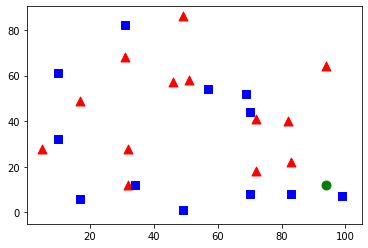

In [5]:
# Nueva entrada (aleatoria)
#--------------------------
newcomer = np.random.randint(0,100,(1,2)).astype(np.float32)

# Creamos el clasificador
#------------------------
knn = cv.ml.KNearest_create()
knn.train(trainData, cv.ml.ROW_SAMPLE, responses)
ret, results, neighbours ,dist = knn.findNearest(newcomer, 5)

# Graficamos para que sea visible dónde está la nueva entrada
#------------------------------------------------------------
fig, ax = plt.subplots()
ax.scatter(red[:,0],red[:,1],80,'r','^')
ax.scatter(blue[:,0],blue[:,1],80,'b','s')
ax.scatter(newcomer[:,0],newcomer[:,1],80,'g','o')

print( "result:  {}\n".format(results) )
print( "neighbours:  {}\n".format(neighbours) )
print( "distance:  {}\n".format(dist) )

plt.show()

### OCR utilizando KNN <br>

Utilizamos el set de dígitos escritos a mano que viene en OpenCV: cv2/samples/data.<br>

La idea es utilizar la imagen de cada dígito de 20x20 píxels tomando los valores de intensidad y armando un vector de 400 características sobre el cual entrenaremos (armaremos un mapa de 400 dimensiones) para luego con una nueva realización (también de dimensión 400) haremos una votación de las k muestras de entrenamiento que le queden más cerca en este multi-espacio para determinar a qué grupo pertenece.

In [6]:
# Leemos la imagen y la convertimos a escala de gris
#---------------------------------------------------
img = cv.imread('digits.png')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

# Dividimos la imagen en 5000 celdas de 20x20 píxels
#---------------------------------------------------
cells = [np.hsplit(row,100) for row in np.vsplit(gray,50)]

# Convertimos las celdas a numpy arrays. El tamaño resultante es de (50,100,20,20)
#--------------------------------------------------------------------------------
x = np.array(cells)
#plt.imshow(x[4,99,:,:])

# Ahora preparamos lo datos de entrenamiento y de testeo (permutando índices)
#----------------------------------------------------------------------------
percentage = 0.7
n = x.shape[1]                    
a = int(percentage * x.shape[1])  
idxs_permutados = np.random.permutation(n)
train_idxs = idxs_permutados[0:a]
test_idxs = idxs_permutados[a:n]

# Las características de cada caracter son simplemente los valores de intensidad colocados como
# vector, es decir un vector de 20x20 = 400 posiciones
#-----------------------------------------------------
train = x[:,train_idxs].reshape(-1,400).astype(np.float32)    # Size = (50*a,400)
test = x[:,test_idxs].reshape(-1,400).astype(np.float32)      # Size = (50*(n-a),400)

# Creamos las etiquetas para datos de entrenamiento y testeo
#-----------------------------------------------------------
k = np.arange(10)
train_labels = np.repeat(k,5*a)[:,np.newaxis]     # Son 5 filas por caracter, de ahí el 5
test_labels = np.repeat(k,5*(n-a))[:,np.newaxis]  # Son 5 filas por caracter, de ahí el 5

# Iniciamos el clasificador (kNN), entrenamos y luego testeamos (con k=3)
#------------------------------------------------------------------------
knn = cv.ml.KNearest_create()
knn.train(train, cv.ml.ROW_SAMPLE, train_labels)
ret,result,neighbours,dist = knn.findNearest(test,k=3)

# Ahora verificamos la exactitud (accuracy) del clasificador. Para esto comparamos los resultados 
# contra las test_labels incorrectas
#-----------------------------------
matches = result==test_labels
correct = np.count_nonzero(matches)
accuracy = correct*100.0/result.size
print('Accuracy: {:.3f} %'.format(accuracy))

# Guardemos los datos de entrenamiento (para ver cuánto ocupa en memoria)
np.savez('knn_data.npz',train=train, train_labels=train_labels)

Accuracy: 93.333 %
